# DTMのコードの関数作成
* time_sliceの作成
 * 年月別ユーザー数でtime_sliceを作成する
* 上記で作成した年月別ユーザー数をリスト化する
* corpus作成のデータ準備
 * ユーザーの年月別購買商品を取得する
 * リスト化
 * ※ここで、ユーザーIDとユーザーの購買履歴を対応づける作業を行う。
* DTMのデータ準備
 * cat4の辞書の作成
 * corpus作成
* DTM実装
 * トピック数を指定する
 * モデルを実行し、モデルを保存する
* DTM結果の可視化
 * 各トピックの年月別割合推移を可視化する
 * サンキーダイアグラムを用いて


In [51]:
pip install japanize-matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
target_data_food = pd.read_csv("cat1_food_data_target_user10_2500.csv", index_col=0)

In [3]:
target_data_food.groupby('cat1').size()

cat1
食料品    22926692
dtype: int64

In [4]:
target_data_food['id'].nunique()

17207

In [5]:
#日付データの形式変更
target_data_food['receipt_buydate'] = pd.to_datetime(target_data_food['receipt_buydate'])

In [9]:
pip install gensim nltk

Note: you may need to restart the kernel to use updated packages.


# classを使ってdtmの前処理を記述

In [6]:
from gensim import corpora, models
import pandas as pd

class Pre_dtm:
    def __init__(self, target_data_food):
        self.target_data_food = target_data_food
        self.user_time_slice = None
        self.user_cat4_ym = None
        self.indices_by_id = None
        self.dictionary = None
        self.corpus = None

    def create_time_slice(self):
        unique_user_count = self.target_data_food.groupby(self.target_data_food['receipt_buydate'].dt.to_period("M"))['id'].nunique().reset_index()
        unique_user_count.columns = ['receipt_buydate', 'unique_user_count']
        self.user_time_slice = unique_user_count['unique_user_count'].tolist()
        return self.user_time_slice

    def prepare_corpus_data(self):
        grouped_cat4_data = self.target_data_food.groupby([self.target_data_food['receipt_buydate'].dt.to_period("M"), 'id'])['cat4'].apply(lambda x: [product.strip() for product in x]).reset_index()
        self.user_cat4_ym = grouped_cat4_data['cat4'].tolist()
        # self.indices_by_id = grouped_cat4_data.groupby('id').apply(lambda x: x.index.tolist())
        # 指定された期間の年月リストを作成
        date_range = pd.date_range(start='2014-04-01', end='2015-03-31', freq='M').strftime('%Y-%m').tolist()
        # IDごとにグループ化し、リストを作成
        result = grouped_cat4_data.groupby('id').apply(lambda group: [group[group['receipt_buydate'].dt.strftime('%Y-%m') == month].index[0].tolist() if month in group['receipt_buydate'].dt.strftime('%Y-%m').tolist() else 'NA' for month in date_range])
        self.indices_by_id = result
        return self.user_cat4_ym, self.indices_by_id

    def create_dictionary(self):
        texts = self.target_data_food['cat4'].tolist()
        processed_docs = [[str(doc).lower().strip()] for doc in texts]
        self.dictionary = corpora.Dictionary(processed_docs)
        return self.dictionary

    def create_corpus(self):
        if self.dictionary is None:
            self.create_dictionary()
        if self.user_cat4_ym is None:
            self.prepare_corpus_data()
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.user_cat4_ym]
        return self.corpus

    def analyze(self):
        self.create_time_slice()
        self.prepare_corpus_data()
        self.create_dictionary()
        self.create_corpus()
        return {
            'time_slice': self.user_time_slice,
            'corpus_data': (self.user_cat4_ym, self.indices_by_id),
            'dictionary': self.dictionary,
            'corpus': self.corpus
        }

In [7]:
# Assuming you have your target_data_food DataFrame
analyzer = Pre_dtm(target_data_food)
results = analyzer.analyze()

# Access the results
user_time_slice = results['time_slice']
user_cat4_ym, indices_by_id = results['corpus_data']
dictionary = results['dictionary']
corpus = results['corpus']

In [10]:
from gensim.models import LdaSeqModel

# DTM実装

In [11]:
ldaseq = LdaSeqModel.load('dtm_cat4_10_all.pkl')

In [12]:
#時系列でのトピックの確率を取得
for time in range(len(user_time_slice)):
    topics_at_time_t = ldaseq.print_topics(time=time)
    for topic_id, topic_prob in enumerate(topics_at_time_t):
        print(topic_id, topic_prob[0:5])

0 [('冷凍調理', 0.4253598853742856), ('冷凍農産', 0.03954752339647178), ('畜肉ソ－セ－ジ', 0.03252891260769376), ('ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺', 0.03250385645351628), ('洋風食品', 0.02849186896472445)]
1 [('コ－ヒ－ドリンク', 0.9067905534206978), ('栄養ドリンク', 0.02087450949572744), ('液体茶', 0.012585886319091402), ('果汁飲料', 0.00799018920830302), ('牛乳', 0.006524455827890604)]
2 [('たばこ', 0.8295788698465559), ('ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺', 0.02831636539714208), ('つまみ類', 0.015328418171487614), ('煎餅・あられ', 0.014113370776168524), ('コ－ラ', 0.013931584140699562)]
3 [('スナック', 0.1819124552622254), ('チョコレ－ト', 0.13134653021177423), ('ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-', 0.08713523706273554), ('キャンディ', 0.07669334377198099), ('煎餅・あられ', 0.06438163424562783)]
4 [('菓子パン・調理パン', 0.6746947446113092), ('食パン', 0.07228892197425277), ('牛乳', 0.035251943311966696), ('ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺', 0.034054317613494346), ('スナック', 0.010059243566055628)]
5 [('ヨ－グルト', 0.2710345488577349), ('牛乳', 0.08306027103918265), ('デザ－ト類', 0.07083754001796982), ('野菜ジユ－ス', 0.06438862736145609), ('乳酸菌飲料', 0.05426851234331248)]
6 [('

In [13]:
from gensim.models import LdaSeqModel
import numpy as np
import datetime


# トピック数を指定,データのタイプを指定
num_topics = 10
data_type = 'all'
def run_dtm(num_topics, user_time_slice, corpus, dictionary):
    ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=user_time_slice, num_topics=num_topics)
    ldaseq.save(f'dtm_cat4_{num_topics}_{data_type}.pkl')


def vis_dtm_result(user_time_slice, num_topic, data_type):
    #各トピックの年月別割合推移を可視化する
    cumulative_list = [sum(user_time_slice[:i+1]) for i in range(len(user_time_slice))]
    #モデルの読み込み
    ldaseq = LdaSeqModel.load(f'dtm_cat4_{num_topics}_{data_type}.pkl')
    # トピックの割合を計算
    time_topic_prob = {}
    start = 0
    for num, index in enumerate(cumulative_list):
        # 各トピックの確率を効率的に平均化
        topic_probs = np.mean(ldaseq.doc_topics(range(start,index)), axis = 0)

        # 結果を格納
        time_topic_prob[num] = topic_probs

        # 次の時間帯の開始点を更新
        start = index
    #可視化の際のインデックスを取得
    times_ = list(target_data_food['receipt_buydate'].dt.to_period("M").unique())
    times_ = [str(str_time) for str_time in times_]
    times_ = sorted(times_, key=lambda x: datetime.datetime.strptime(x, "%Y-%m"))

    # データの準備
    data = time_topic_prob
    # データを時間とトピック別に整理
    times = list(data.keys())
    topic_prob_data = [[data[t][s] for t in times] for s in range(num_topic)]
    for i in range(num_topic):
        plt.plot(times_, topic_prob_data[i],label=f'Topic{i}')
    # グラフのスタイリング
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Topic Proportion', fontsize=12)
    plt.title('Topic Evolution Over Time', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    # plt.legend(loc='upper right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{data_type}propotion.png", dpi=700)
    plt.show()

C:\Users\nama\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)


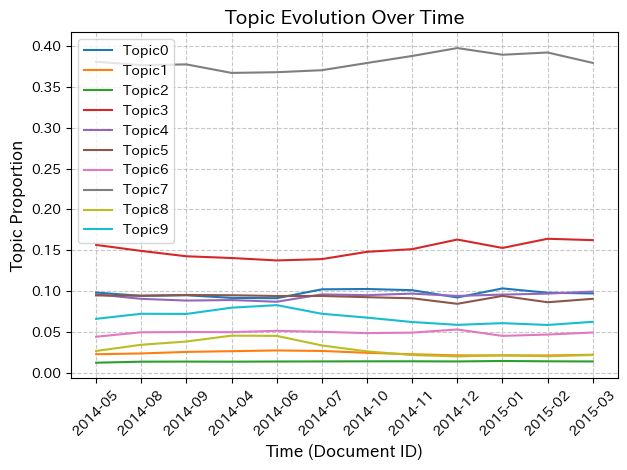

In [14]:
run_dtm(num_topics, user_time_slice, corpus, dictionary)


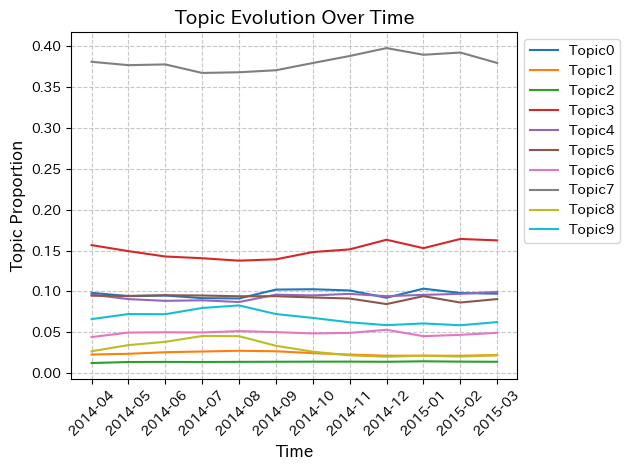

In [14]:
vis_dtm_result(user_time_slice, num_topics, data_type)

In [15]:
ldaseq = LdaSeqModel.load('dtm_cat4_10_all.pkl')
#時系列でのトピックの確率を取得
user_time_slice = 12
tmp_dic = {}
for time in range(user_time_slice):
    topics_at_time_t = ldaseq.print_topics(time=time)
    for topic_id, topic_prob in enumerate(topics_at_time_t):
        print(topic_id, topic_prob[0:8])
        tmp_dic[topic_id] = topic_prob[0:5]
pd.DataFrame(tmp_dic)

0 [('冷凍調理', 0.4253598853742856), ('冷凍農産', 0.03954752339647178), ('畜肉ソ－セ－ジ', 0.03252891260769376), ('ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺', 0.03250385645351628), ('洋風食品', 0.02849186896472445), ('冷凍水産', 0.027070973650177785), ('ﾒﾆｭ-専用料理の素', 0.020286174702864826), ('ふりかけ', 0.018432682540557386)]
1 [('コ－ヒ－ドリンク', 0.9067905534206978), ('栄養ドリンク', 0.02087450949572744), ('液体茶', 0.012585886319091402), ('果汁飲料', 0.00799018920830302), ('牛乳', 0.006524455827890604), ('紅茶ドリンク', 0.00520481370684526), ('スナック', 0.004822759559353899), ('チュ－インガム', 0.004412757435177239)]
2 [('たばこ', 0.8295788698465559), ('ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺', 0.02831636539714208), ('つまみ類', 0.015328418171487614), ('煎餅・あられ', 0.014113370776168524), ('コ－ラ', 0.013931584140699562), ('液体茶', 0.009319506779402834), ('焼酎', 0.00848087318434444), ('チュ－インガム', 0.007513992832641159)]
3 [('スナック', 0.1819124552622254), ('チョコレ－ト', 0.13134653021177423), ('ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-', 0.08713523706273554), ('キャンディ', 0.07669334377198099), ('煎餅・あられ', 0.06438163424562783), ('ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺', 0.03639446552557223),

,0,1,2,3,4,5,6,7,8,9
0,"(冷凍調理, 0.40672409515859675)","(コ－ヒ－ドリンク, 0.9025886495925006)","(たばこ, 0.8328608909814432)","(スナック, 0.18406616121311065)","(菓子パン・調理パン, 0.6743039829526374)","(ヨ－グルト, 0.2947806195626624)","(ビ－ル, 0.2846073935267409)","(豆腐類, 0.0888965371169658)","(アイスクリ－ム, 0.7897202195325052)","(液体茶, 0.26810767057166385)"
1,"(冷凍農産, 0.039339180152506384)","(栄養ドリンク, 0.020571277942057396)","(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.033913375997722504)","(チョコレ－ト, 0.12408242167104097)","(食パン, 0.06086003080448788)","(牛乳, 0.07869275944288805)","(その他酒類, 0.2586896154400735)","(食パン, 0.05965025418812096)","(デザ－ト類, 0.04897824953322034)","(炭酸飲料, 0.07694466681457897)"
2,"(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.03893005209682521)","(液体茶, 0.011920069999282657)","(つまみ類, 0.016953479088591933)","(ﾋﾞｽｹﾂﾄ&ｸﾗﾂｶ-, 0.09321688688768288)","(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.0379423501759504)","(野菜ジユ－ス, 0.058621611771997977)","(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.06188701388745292)","(牛乳, 0.05882573773331935)","(炭酸飲料, 0.042337548512513375)","(ミネラルウォ－タ類, 0.07207429093664237)"
3,"(洋風食品, 0.029930523564157867)","(その他飲料, 0.010771927870713252)","(焼酎, 0.010848579183521964)","(キャンディ, 0.06870912148812237)","(牛乳, 0.03139841943745919)","(デザ－ト類, 0.05438975693537821)","(焼酎, 0.04705729253454859)","(生麺・ゆで麺, 0.041407528960679285)","(コ－ラ, 0.019264517247379587)","(ｶｯﾌﾟｲﾝｽﾀﾝﾄ麺, 0.07144434222102891)"
4,"(冷凍水産, 0.029544115446325656)","(果汁飲料, 0.010216980747355893)","(煎餅・あられ, 0.010001736992274435)","(煎餅・あられ, 0.06775780876687776)","(その他菓子, 0.012324390320663155)","(乳酸菌飲料, 0.04788839285919681)","(ワイン, 0.04174578080703883)","(納豆, 0.04092479671848034)","(サイダ－, 0.014266793635551655)","(コ－ラ, 0.06787524750266595)"


In [16]:
# 年月リスト（例: 2014年4月～2015年3月）
time_labels = pd.date_range(start="2014-04-01", end="2015-03-01", freq="MS").strftime("%Y-%m").tolist()

# 検証用: 出力する全データを保持するリスト
all_rows = []

# トピックデータの処理とラベル付け
for time, label in enumerate(time_labels):
    topics_at_time_t = ldaseq.print_topics(time=time)  # 各タイムスライスのトピックを取得
    rows = []
    for topic_id, topic in enumerate(topics_at_time_t):
        # トピックごとのデータ整形
        row = {"年月": label, "トピック": topic_id}
        for rank, (word, prob) in enumerate(topic[:5], start=1):  # 上位5つを取得
            row[f"{rank} 位"] = f"{word} ({prob:.3f})"
        rows.append(row)
    all_rows.extend(rows)  # 全タイムスライスのデータをまとめる

# データフレーム化
df = pd.DataFrame(all_rows)
output_file = "dtm_topic/dtm_topic_all.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")

In [74]:
import datetime

times_ = list(target_data_food['receipt_buydate'].dt.to_period("M").unique())
times_ = [str(str_time) for str_time in times_]

# 年月順にソート
times_ = sorted(times_, key=lambda x: datetime.datetime.strptime(x, "%Y-%m"))

# ソート結果を表示
print(times_sorted)

['2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03']


# サンキーダイアグラムの可視化

In [17]:
from collections import defaultdict
import numpy as np

def analyze_cluster_transitions(indices_by_id, ldaseq):
    def create_user_cluster_dict(indices_by_id, ldaseq):
        # indices_by_id = pd.DataFrame(indices_by_id).reset_index()
        # indices_by_id.columns = ['id', 'doc_list']
        # user_cluster_dic = {}
        # for id, doc_list in zip(indices_by_id['id'], indices_by_id['doc_list']):
        #     clus_list = []
        #     num = 0
        #     for doc_num in doc_list:
        #         bel_ind = np.argmax(ldaseq.doc_topics(doc_num))
        #         clus_list.append(f'{bel_ind}_{num}')
        #         num += 1
        #     user_cluster_dic[id] = clus_list
        #年月別で存在しない場合はNAを入力するコードに変更
        user_cluster_dic={}
        indices_by_id = pd.DataFrame(indices_by_id).reset_index()
        indices_by_id.columns = ['id', 'doc_list']
        for id, doc_list in zip(indices_by_id['id'], indices_by_id['doc_list']):
            clus_list = []
            num = 0
            for doc_num in doc_list:
                if doc_num == 'NA':
                    clus_list.append(f'{100}_{num}')
                else:
                    bel_ind = np.argmax(ldaseq.doc_topics(doc_num))
                    clus_list.append(f'{bel_ind}_{num}')
                num += 1
            user_cluster_dic[id] = clus_list
        return user_cluster_dic

    def count_transitions(cluster_sequences):
        transition_counts = defaultdict(int)
        for cluster_sequence in cluster_sequences:
            for i in range(len(cluster_sequence) - 1):
                current_cluster = cluster_sequence[i]
                next_cluster = cluster_sequence[i + 1]
                transition = (current_cluster, next_cluster)
                transition_counts[transition] += 1
        return transition_counts

    def prepare_sankey_data(transition_counts):
        source = []
        target = []
        values_list = []
        for item, value in transition_counts.items():
            source.append(item[0])
            target.append(item[1])
            values_list.append(value)
        return source, target, values_list

    user_cluster_dic = create_user_cluster_dict(indices_by_id, ldaseq)
    cluster_sequences = user_cluster_dic.values()
    transition_counts = count_transitions(cluster_sequences)

    # 結果の出力
    for transition, count in transition_counts.items():
        print(f"遷移 {transition} は {count} 回発生しました。")

    source, target, values_list = prepare_sankey_data(transition_counts)

    return user_cluster_dic, transition_counts, source, target, values_list


In [18]:
indices_by_id

id
0.0        [0, 17205, 34412, 51618, 68825, 86031, 103238,...
2.0        [1, 17206, 34413, 51619, 68826, 86032, 103239,...
4.0        [2, 17207, 34414, 51620, 68827, 86033, 103240,...
5.0        [3, 17208, 34415, 51621, 68828, 86034, 103241,...
6.0        [4, 17209, 34416, 51622, 68829, 86035, 103242,...
                                 ...                        
40338.0    [17200, 34407, 51613, 68820, 86026, 103233, 12...
40343.0    [17201, 34408, 51614, 68821, 86027, 103234, 12...
40344.0    [17202, 34409, 51615, 68822, 86028, 103235, 12...
40349.0    [17203, 34410, 51616, 68823, 86029, 103236, 12...
40350.0    [17204, 34411, 51617, 68824, 86030, 103237, 12...
Length: 17207, dtype: object

In [19]:
# indices_by_id と ldaseq が既に定義されていると仮定
user_cluster_dic, transition_counts, source, target, values_list = analyze_cluster_transitions(indices_by_id, ldaseq)

# 返された値を使って後続の処理を行う
# 例: サンキーダイアグラムの作成など

遷移 ('7_0', '7_1') は 8902 回発生しました。
遷移 ('7_1', '7_2') は 9030 回発生しました。
遷移 ('7_2', '7_3') は 8938 回発生しました。
遷移 ('7_3', '7_4') は 8802 回発生しました。
遷移 ('7_4', '7_5') は 8786 回発生しました。
遷移 ('7_5', '7_6') は 8852 回発生しました。
遷移 ('7_6', '7_7') は 9027 回発生しました。
遷移 ('7_7', '7_8') は 9132 回発生しました。
遷移 ('7_8', '7_9') は 9083 回発生しました。
遷移 ('7_9', '7_10') は 9015 回発生しました。
遷移 ('7_10', '7_11') は 8862 回発生しました。
遷移 ('7_4', '5_5') は 219 回発生しました。
遷移 ('5_5', '7_6') は 217 回発生しました。
遷移 ('7_9', '5_10') は 152 回発生しました。
遷移 ('5_10', '7_11') は 156 回発生しました。
遷移 ('1_0', '1_1') は 131 回発生しました。
遷移 ('1_1', '1_2') は 138 回発生しました。
遷移 ('1_2', '1_3') は 131 回発生しました。
遷移 ('1_3', '2_4') は 7 回発生しました。
遷移 ('2_4', '1_5') は 7 回発生しました。
遷移 ('1_5', '2_6') は 10 回発生しました。
遷移 ('2_6', '1_7') は 7 回発生しました。
遷移 ('1_7', '1_8') は 126 回発生しました。
遷移 ('1_8', '2_9') は 7 回発生しました。
遷移 ('2_9', '1_10') は 7 回発生しました。
遷移 ('1_10', '2_11') は 7 回発生しました。
遷移 ('7_8', '0_9') は 407 回発生しました。
遷移 ('0_9', '0_10') は 589 回発生しました。
遷移 ('0_10', '7_11') は 268 回発生しました。
遷移 ('3_0', '3_1') は 1484 回発生しました。

In [24]:
import pandas as pd
import plotly.graph_objects as go

def create_color_mapping():
    return {
        '0': 'blue', '1': 'green', '2': 'red', '3': 'orange',
        '4': 'purple', '5': 'yellow', '6': 'cyan', '7': 'magenta',
        '8': 'lime', '9': 'pink',  '100': 'brown'
    }

def prepare_sankey_data(source, target, values_list):
    unique_nodes = list(set(source + target))
    node_indices = {node: i for i, node in enumerate(unique_nodes)}

    color_mapping = create_color_mapping()
    color_list = [color_mapping[node.split('_')[0]] for node in unique_nodes]

    source_indices = [node_indices[node] for node in source]
    target_indices = [node_indices[node] for node in target]

    return unique_nodes, color_list, source_indices, target_indices

def create_sankey_diagram_with_dates(source, target, values_list, dates):
    unique_nodes, color_list, source_indices, target_indices = prepare_sankey_data(source, target, values_list)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20,
            thickness=40,
            line=dict(color="black", width=0.5),
            label=unique_nodes,
            color=color_list
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values_list
        )
    )])

    # 各列に異なる年月を追加
    annotations = []
    for i, date in enumerate(column_dates):
        annotations.append(
            dict(
                text=date,  # 表示する年月
                x= i * 0.09,  # x軸を各列に対応（間隔を調整）
                y=-0.05,  # y軸の位置をグラフ上部に固定
                showarrow=False,
                font=dict(size=12),
                xref="paper",  # x座標を「描画エリア」で相対指定
                yref="paper"   # y座標を「描画エリア」で相対指定
            )
        )

    fig.update_layout(
        annotations=annotations,  # 全ての注釈を追加
        width=2000,
        height=600,
        margin=dict(l=10, r=10, t=10, b=50)  # 余白を調整
    )

    return fig


# 使用例
column_dates =pd.date_range(start="2014-04-01", end="2015-03-01", freq="MS").strftime("%Y-%m").tolist()
fig = create_sankey_diagram_with_dates(source, target, values_list, dates)

# 保存時の余白を最小化
fig.write_image("sankey_all.png", format="png", scale=2, width=2000, height=650)  # 余白を考慮したサイズ
fig.show()